In [1]:
import importlib
import fastai
import os

In [2]:
from fastai.vision.all import *
from shutil import copyfile

In [3]:
mount_path = "/root/data/cv1_transfer/"
ml_data_path = os.path.join(mount_path, "labeled_data")

In [4]:
path = Path(ml_data_path)

oil_chps = np.loadtxt(path/'oil_chps.txt', dtype=str)
codes = np.loadtxt(path/'codes.txt', dtype=str)
valid_names = np.loadtxt(path/'valid_names.txt', dtype=str)

In [5]:
import skimage.io as skio
import numpy as np

labels = path/"lbl"
labels_no_3 = path/"lbl_no3"

os.makedirs(labels_no_3, exist_ok=True)

vals = set()
for i in labels.glob("*.png"):
    arr = skio.imread(i)
    values = np.unique(arr)
    arr[arr==3] = 0
    try:
        skio.imsave(labels_no_3 / i.name, arr, check_contrast=False)
    except:
        continue

In [6]:
random.seed(42)
oilless_chps = [chp for chp in get_image_files(path/'chp') if chp.stem not in oil_chps]
density = 0
num_oilless = density * len(oil_chps)
mixed_chps = random.sample(oilless_chps,num_oilless) + [path/'chp'/(chp+'.png') for chp in oil_chps]
len(mixed_chps)

473

In [7]:
def get_chps(path): return mixed_chps
def get_lbls(fn): return fn.parent.parent/"lbl_no3"/f"{fn.name}"
def splitter_func(fn): return fn.name.rsplit('_',1)[0] in valid_names # XXX Check to make sure this should be returning True for Valid

drive_files = get_chps(path)

In [8]:
lcl = Path("../out_data")
path.mkdir(exist_ok=True)
modelpath = lcl

use_lcl = False
if use_lcl:
  path = lcl
  lcl_chp = path/"chp"
  lcl_lbl = path/"lbl_no3"
  lcl_chp.mkdir(exist_ok=True)
  lcl_lbl.mkdir(exist_ok=True)
  for i, f in enumerate(drive_files): # 10 minutes?!
    if not i%50: print(i, f)
    if not (lcl_chp/f.name).exists():
      copyfile(f, lcl_chp/f.name)
    if not (lcl_lbl/f.name).exists():
      copyfile(get_lbls(f), lcl_lbl/f.name)

In [9]:
size = 64 # Progressive resizing could happen here
augs = aug_transforms(flip_vert=True, max_warp=0.1, size=size)

In [10]:
seg_db = DataBlock(
    blocks=(ImageBlock, MaskBlock(codes=codes)),
    get_items = get_chps,
    splitter=FuncSplitter(splitter_func),
    batch_tfms=augs,
    get_y=get_lbls)

In [ ]:
dls = SegmentationDataLoaders.from_dblock(
    dblock = seg_db,
    source = path,
    path = path,
    bs = 4)

In [ ]:
seg_db.summary(path)

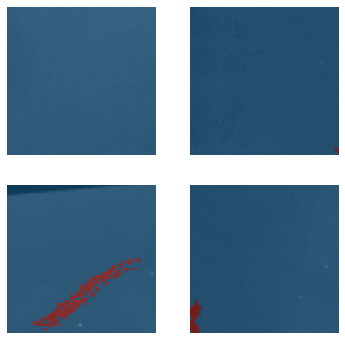

In [14]:
dls.show_batch(vmin=0, vmax=3)

In [15]:
# add best model callback saver
# write to drive not lcl

In [16]:
arch = 18
archs = {18: resnet18, 34: resnet34, 50: resnet50}

In [17]:
learn = unet_learner(dls, archs[arch], metrics=[Dice()], model_dir=modelpath, cbs=[MixedPrecision])

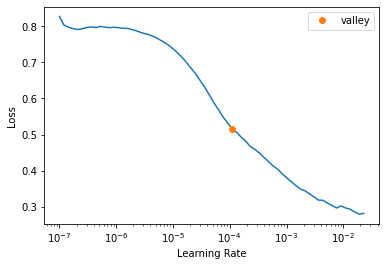

In [19]:
lr = learn.lr_find()

In [20]:
lr

SuggestedLRs(valley=0.00010964782268274575)

In [19]:
learn.fine_tune(5, 2e-4)#, cbs=SaveModelCallback(monitor='dice'))

epoch,train_loss,valid_loss,dice,time
0,0.076517,0.041192,0.000000,00:05


epoch,train_loss,valid_loss,dice,time
0,0.029031,0.035402,0.000000,00:06
1,0.025283,0.028970,0.043871,00:06
2,0.022743,0.026429,0.339275,00:06
3,0.020582,0.024505,0.331167,00:05
4,0.019285,0.024911,0.274623,00:05


In [20]:
# learn.load("model")

In [21]:
learn

In [ ]:
savename = f'{density}_{arch}_{size}_{round(learn.validate()[1],3)}.pkl'
learn.export(modelpath/savename)

In [ ]:
learn.show_results(max_n=4, figsize=(20,20), vmin=0, vmax=3)